In [1]:
from dataclasses import dataclass, field
from collections.abc import Callable, Mapping, Sequence
import itertools
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import xarray as xr

from HARK import distribution

In [2]:
from stage import Stage, backwards_induction

# General Bellman Stage Form

The agent:
 - begins in some input states $\vec{X} \in \vec{X}$
 - experiences some exogeneous shocks $\vec{k} \in \vec{K}$
 - can choose some actions $\vec{a} \in \vec{A}$
 - subject to constraints $\Gamma: \vec{X} \times \vec{K} \times \vec{A} \rightarrow \mathbb{B}$
 - experience a reward $F: \vec{X} \times \vec{K} \times \vec{A} \rightarrow \mathbb{R}$
 - together, these determine some output states $\vec{y} \in \vec{Y}$ via...
 - a **deterministic** transition function $T: \vec{X} \times \vec{K} \times \vec{A} \rightarrow \vec{Y}$
   - _This is deterministic because shocks have been isolated to the beginning of the stage._
   - CDC thinks there needs to be an additional between-stage transition function.
 - The agent has a discount factor $\beta$ for future utility.
   - CDC: These can be a function of...

## Solving one stage

For any stage, consider two value functions.
 - $v_x : X \rightarrow \mathbb{R}$ is the value of its input states
 - $v_y : Y \rightarrow \mathbb{R}$ is the value of its output states. Others migth write this $\mathfrak{v}$'
 - $\hat{v}_y : X \times K \times A \rightarrow \mathbb{R} $
 
The stage is solved with respect to a value function $v_y : \vec{Y} \rightarrow \mathbb{R}$ over the output states. The $q: \vec{X} \times \vec{K} \times \vec{A} \rightarrow \mathbb{R}$ is the value of a state, shock, action combination.

$$q(\vec{x}, \vec{k}, \vec{a}) = F(\vec{x}, \vec{k}, \vec{a}) + \overbrace{\beta(\vec{x},\vec{k},\vec{a}) v_y(T(\vec{x}, \vec{k}, \vec{a}))}^{\hat{v}_y}$$

where $\beta$ is the agent's discount factor for that stage. Note that there is no expecation taking in this operation because $T$ is deterministic.

The optimal policy $\pi: \vec{X} \times \vec{K} \rightarrow \vec{A}$ is:

$$\pi^*(\vec{x}, \vec{k}) = \mathrm{argmax}_{\vec{a} \in \vec{A}} q(\vec{x}, \vec{k}, \vec{a})$$

(This is solved by griding over $x$ and $k$ ...)

The optimal policy $\pi^*$ can then be used to derive the value function over the input states $V_x: \vec{X} \rightarrow \mathbb{R}$.

$$v_x(\vec{x}) = \mathbb{E}_{\vec{k} \in \vec{K}}[q(\vec{x}, \vec{k}, \pi^*(\vec{x}, \vec{k}))]$$

Note that this requires no optimization, but does require the taking of expectations over the probability distribution over the shocks.

**TODO**: Clean up notebook -- move smoke tests to tests. Automate tests of core code.

**TODO**: Notebook showing two different implementations of the portfolio choice problem, with different solution times.

**TODO**: Forward simulation

 - **TODO** : Shocks
   - Forward-simulation with discretized shock values
   
**TODO**: Type aliases for the function domains $X$, $A$, $K$, etc.

**TODO**:  Parameters
 - Allowing for parameters in stage function scope (e.g., CRRA, PermGroFac)
 
**TODO**: Time varying parameters-- distribute over multiple stages

**TODO**: Infinite horizon portfolio choice solver with arbitrary grids

**TODO**: EGM. [Analysis -- what would it speed up?]

**TODO**: Correlated shocks. [Unsolved problem!]


# Portfolio Choice Problem

## Stages

First we define the stages. Then we combine the stages together and solve them recursively.

### Consumption stage

Example: The consumption stage:

* $c \in A_0 = \mathbb{R}$
* $m \in X_0 = \mathbb{R}$
* $a \in Y_0 = \mathbb{R}$
* $\Gamma_0$ ... restricts consumption $c \leq m$
* $F_0(m,c) = CRRA(c, \rho)$
* $T_0(m,c) = m - c$ 
* $\beta_0 = \beta $

Requires a parameter $\rho$

In [3]:
from HARK.utilities import CRRAutility

CRRA = 5

consumption_stage = Stage(
    transition = lambda x, k, a : {'a' : x['m'] - a['c']}, 
    reward = lambda x, k, a : CRRAutility(a['c'], CRRA), 
    inputs = ['m'], 
    actions = ['c'],
    outputs = ['a'],
    constraints = [lambda x, k, a: x['m'] - a['c']], # has to be nonnegative to clear
    discount = .96 # lambda x, k, a : .96 * k['psi']^(1 - CRRA) < --- 
)

AL: What about non-additive value functions?

To be more consistent with AL, pass grids in as DataArrays

In [4]:
def consumption_v_y(y : Mapping[str,...]):
    return CRRAutility(y['a'], CRRA)

pi_star, q = consumption_stage.optimal_policy({'m' : [9, 11, 20, 300, 4000, 5500]}, v_y = consumption_v_y)

q

Grid size: 6.0


/home/sb/projects/HARK/HARK/utilities.py:141: RuntimeWarning: divide by zero encountered in double_scalars
  return c ** (1.0 - gam) / (1.0 - gam)


<xarray.DataArray (m: 6)>
array([-1.19474070e-03, -5.35393332e-04, -4.89918359e-05, -9.67739967e-10,
       -3.06198974e-14, -8.56629327e-15])
Coordinates:
  * m        (m) int64 9 11 20 300 4000 5500

In [5]:
consumption_stage.T({'m' : 100}, {}, {'c' : 50})

{'a': 50}

In [6]:
consumption_stage.T({'m' : 100}, {}, {'c' : 101})

{'a': -1}

In [7]:
consumption_stage.reward({'m' : 100}, {}, {'c' : 50})

-4e-08

In [8]:

consumption_stage.q({'m' : 100}, {}, {'c' : 50}, v_y = consumption_v_y)

-7.84e-08

In [9]:
consumption_stage.solve({'m' : [0, 50, 100, 1000]}, {}, consumption_v_y)

Grid size: 4.0


<xarray.Dataset>
Dimensions:  (m: 4)
Coordinates:
  * m        (m) int64 0 50 100 1000
Data variables:
    v_x      (m) float64 -1.291e+17 -1.254e-06 -7.839e-08 -7.839e-12
    pi*      (m) float64 4.414e-05 25.1 50.2 502.0
    q        (m) float64 -1.291e+17 -1.254e-06 -7.839e-08 -7.839e-12

### Allocation stage

The allocation stage. Note that this is a trivial transition function.:

* $\alpha \in A_1 = \mathbb{R}$
* $a \in X_1 = \mathbb{R}$
* $(a, \alpha) \in Y_1 = \mathbb{R}^2$
* $\Gamma_1$ ... restricts allocation $0 \leq \alpha \leq 1$
* $F_1(a,\alpha) = 0$
* $T_1(a,\alpha) = (a, \alpha)$
* $\beta_1 = 1 $

In [10]:
allocation_stage = Stage(
    transition = lambda x, k, a : {'a' : x['a'], 'alpha' : a['alpha']}, 
    inputs = ['a'], 
    actions = ['alpha'],
    outputs = ['a', 'alpha'],
    constraints = [
        lambda x, k, a: 1 - a['alpha'], 
        lambda x, k, a: a['alpha']
    ]
)

In [11]:
allocation_stage.T({'a': 100}, {}, {'alpha' : 0.5})

{'a': 100, 'alpha': 0.5}

In [12]:
allocation_stage.T({'a': 100}, {}, {'alpha' : -0.1})

{'a': 100, 'alpha': -0.1}

In [13]:
allocation_stage.reward({'a': 100}, {}, {'alpha' : 0.5})

0

Optimize portfolio allocation $\alpha$ with a more complex value function:

In [14]:
def allocation_v_y(y : Mapping[str,...]):
    return CRRAutility(y['alpha'] * y['a'] + 1,CRRA) \
            + CRRAutility((1 - y['alpha']) * y['a'] + 1, CRRA * 0.9) 

pi_star, q = allocation_stage.optimal_policy({'a' : [9, 11, 20, 300, 4000, 5500]}, v_y = consumption_v_y)

q

Grid size: 6.0


<xarray.DataArray (a: 6)>
array([-3.81039476e-05, -1.70753364e-05, -1.56250000e-06, -3.08641975e-11,
       -9.76562500e-16, -2.73205382e-16])
Coordinates:
  * a        (a) int64 9 11 20 300 4000 5500

In [15]:
allocation_stage.solve({'a' : [0, 50, 100, 1000]}, {}, allocation_v_y)

Grid size: 4.0


<xarray.Dataset>
Dimensions:  (a: 4)
Coordinates:
  * a        (a) int64 0 50 100 1000
Data variables:
    v_x      (a) float64 -0.5357 -2.993e-06 -2.495e-07 -5.695e-11
    pi*      (a) float64 0.0 0.412 0.3964 0.3428
    q        (a) float64 -0.5357 -2.993e-06 -2.495e-07 -5.695e-11

### Growth stage

The growth stage stage:

* $A_2 = \emptyset$
* $(a, \alpha) \in X_2 = \mathbb{R}^2$
* $m \in Y_0 = \mathbb{R}$
* Shocks:
    * $\psi \sim \text{Lognormal}(0,\sigma_\psi)$
    * $\theta \sim \text{Lognormal}(0,\sigma_\theta)$
    * $\eta \sim \text{Lognormal}(0,\sigma_\eta)$
* $F_2(a,\alpha) = 0$
* $T_2(a,\alpha) =  \frac{(\alpha \eta + (1 - \alpha) R) a + \theta}{\psi G} $ 
* $\text{discount}(\psi) = \beta L \psi^{1-\rho}$ ?? where $L$ is chance to remain alive

Requires parameters $R$ and $G$

In [16]:
R = 1.01
G = 1.02

sigma_psi = 1.05
sigma_theta = 1.15
sigma_eta = 1.1
p_live = 0.98

def growth_transition(x, k, a): 
    return {'m' : ((x['alpha'] * k['eta'] + (1 - x['alpha']) * R) 
                   * x['a'] + k['theta']) 
            / (k['psi'] * G)}

growth_stage = Stage(
    transition = growth_transition,
    inputs = ['a', 'alpha'],
    discount = lambda x, k, a: p_live * k['psi'] ** (1 - CRRA), 
    shocks = {
        'psi' : distribution.Lognormal(0, sigma_psi),
        'theta' : distribution.Lognormal(0, sigma_theta),
        'eta' : distribution.Lognormal(0, sigma_eta),
        # 'live' : distribution.Bernoulli(p_live) ## Not implemented for now
    },
    outputs = ['m'],
)

In [17]:
growth_stage.T(
    {'a': 100, 'alpha' : 0.5},
    {'psi' : 1.00, 'theta' : 1.10, 'eta' : 1.05, 'live' : 1},
    {}
)

{'m': 102.05882352941175}

**TODO**: What is this returning? There ar no actions to optimize!

In [18]:
def growth_v_y(y : Mapping[str,...]):
    return CRRAutility(y['m'], CRRA) # * 'live' ?

pi_star, q = growth_stage.optimal_policy(
    {'a' : [300, 600],
     'alpha' : [0, 1.0]
    },
    {'psi' : [1., 1.1], 
     'theta' : [1., 1.1], 
     'eta' : [1., 1.1],
     # 'live' : [0, 1] 
    }, 
    v_y = growth_v_y)

q

Grid size: 32


<xarray.DataArray (a: 2, alpha: 2, psi: 2, theta: 2, eta: 2)>
array([[[[[-3.10507745e-11, -3.10507745e-11],
          [-3.10099518e-11, -3.10099518e-11]],

         [[-3.10507745e-11, -3.10507745e-11],
          [-3.10099518e-11, -3.10099518e-11]]],


        [[[-3.23073093e-11, -2.20930053e-11],
          [-3.22644116e-11, -2.20663269e-11]],

         [[-3.23073093e-11, -2.20930053e-11],
          [-3.22644116e-11, -2.20663269e-11]]]],



       [[[[-1.95349366e-12, -1.95349366e-12],
          [-1.95220688e-12, -1.95220688e-12]],

         [[-1.95349366e-12, -1.95349366e-12],
          [-1.95220688e-12, -1.95220688e-12]]],


        [[[-2.03267939e-12, -1.38918771e-12],
          [-2.03132709e-12, -1.38834737e-12]],

         [[-2.03267939e-12, -1.38918771e-12],
          [-2.03132709e-12, -1.38834737e-12]]]]])
Coordinates:
  * a        (a) int64 300 600
  * alpha    (alpha) float64 0.0 1.0
  * psi      (psi) float64 1.0 1.1
  * theta    (theta) float64 1.0 1.1
  * eta      (eta) float64 1.0 1.1

In [19]:
sol = growth_stage.solve(
    {'a' : [0, 500, 1000], 'alpha' : [0, 0.5, 1.0]},
    {
        'psi' : 4, 
        'theta' : 4, 
        'eta' : 4,
     # 'live' : [0, 1] 
    }, growth_v_y)

sol.dataset

Grid size: 576


<xarray.Dataset>
Dimensions:  (a: 3, alpha: 3, psi: 4, theta: 4, eta: 4)
Coordinates:
  * a        (a) int64 0 500 1000
  * alpha    (alpha) float64 0.0 0.5 1.0
  * psi      (psi) float64 0.2937 0.7257 1.435 4.487
  * theta    (theta) float64 0.2638 0.7054 1.489 5.291
  * eta      (eta) float64 0.2783 0.7155 1.462 4.869
Data variables:
    v_x      (a, alpha) float64 -13.98 -13.98 -13.98 ... -5.283e-13 -1.102e-11
    pi*      (a, alpha, psi, theta, eta) float64 nan nan nan nan ... nan nan nan
    q        (a, alpha, psi, theta, eta) float64 -54.79 -54.79 ... -4.696e-16

In [20]:
sol = growth_stage.solve(
    {'a' : [0, 250, 500, 750, 1000], 'alpha' : [0, 0.2, 0.4, 0.6, 0.8, 1.0]},
    {
        'psi' : 4, 
        'theta' : 4, 
        'eta' : 4,
     # 'live' : [0, 1] 
    }, growth_v_y)

sol.v_x({'a' : 300, 'alpha' : 0.25})

Grid size: 1920


<xarray.DataArray 'v_x' ()>
array(-5.75831038e-11)
Coordinates:
    a        int64 300
    alpha    float64 0.25

In [21]:
sol.dataset.data_vars

Data variables:
    v_x      (a, alpha) float64 -13.98 -13.98 -13.98 ... -2.204e-12 -1.102e-11
    pi*      (a, alpha, psi, theta, eta) float64 nan nan nan nan ... nan nan nan
    q        (a, alpha, psi, theta, eta) float64 -54.79 -54.79 ... -4.696e-16

### Split Growth

#### $\eta$ Risky growth

The growth stage stage:

* $A_2 = \emptyset$
* $(a, \alpha) \in X_2 = \mathbb{R}^2$
* $a_\eta \in Y_0 = \mathbb{R}$
* Shocks:
    * $\eta \sim \text{Lognormal}(0,\sigma_\eta)$
* $F_2(a,\alpha) = 0$
* $T_2(a,\alpha) =  \alpha \eta + (1 - \alpha) R$
* $\beta = L$

Requires parameter $R$.

#### $\theta$ Transitory Growth

* $A_2 = \emptyset$
* $a_\eta \in X_2 = \mathbb{R}$
* $a_\theta \in Y_0 = \mathbb{R}$
* Shocks:
    * $\theta \sim \text{Lognormal}(0,\sigma_\theta)$
* $F_2(a,\alpha) = 0$
* $T_2(a,\alpha) =  a_\eta + \theta$ 

#### $\psi$ Permanent growth

* $A_2 = \emptyset$
* $a_\theta \in X_2 = \mathbb{R}$
* $m \in Y_0 = \mathbb{R}$
* Shocks:
    * $\psi \sim \text{Lognormal}(0,\sigma_\psi)$
* $F_2(a,\alpha) = 0$
* $T_2(a,\alpha) =  \frac{a_\theta}{R\psi}$
* $\beta(\psi) = \psi^{1 - \rho}$ ??

In [28]:
def risky_growth_transition(x, k, a): 
    return {'a_eta' : ((x['alpha'] * k['eta'] + (1 - x['alpha']) * R))}

risky_growth_stage = Stage(
    transition = growth_transition,
    inputs = ['a', 'alpha'],
    discount = lambda x, k, a: p_live, 
    shocks = {
        'eta' : distribution.Lognormal(0, sigma_eta),
        # 'live' : distribution.Bernoulli(p_live) ## Not implemented for now
    },
    outputs = ['a_eta'],
)

transitory_growth_stage = Stage(
    transition = lambda x, k, a : {'a_theta' : (x['a_eta'] + k['theta'])},
    inputs = ['a_eta'],
    shocks = {
        'theta' : distribution.Lognormal(0, sigma_theta),
        # 'live' : distribution.Bernoulli(p_live) ## Not implemented for now
    },
    outputs = ['a_theta'],
)

permanent_growth_stage = Stage(
    transition = lambda x, k, a : {'a_theta' : (x['a_theta'] / ( k['psi'] * G))},
    inputs = ['a_theta'],
    discount = lambda x, k, a: k['psi'] ** (1 - CRRA), 
    shocks = {
        'psi' : distribution.Lognormal(0, sigma_psi),
        # 'live' : distribution.Bernoulli(p_live) ## Not implemented for now
    },
    outputs = ['m'],
)

## Backward Induction Solver

We chain together the stages and iterative solve each stage backwards, feeding $v_x$ into $v_y$, until convergence.

In [47]:
stages_data = [
    {
        'stage' : consumption_stage,
        'x_grid' : {'m' : np.linspace(0,500,20)}
    },
    {
        'stage' : allocation_stage,
        'x_grid' : {'a' : np.linspace(0,500,20)}
    },
    {
        'stage' : growth_stage,
        'x_grid' : {
            'a' : np.linspace(0,500,20),
            'alpha' : np.linspace(0,1,11)
        },
        'shock_approx_params' : {
            'psi' : 5, 
            'theta' : 5, 
            'eta' : 5,
        }
    }
]

In [48]:
stagesX5 = stages_data * 2

In [49]:
len(stagesX5)

6

In [50]:
## Doing this because of the CRRAutility warnings

import warnings
warnings.filterwarnings('ignore')


In [51]:
def growth_v_y_terminal(y : Mapping[str,...]):
    return 0

In [52]:
sols = backwards_induction(stagesX5, growth_v_y_terminal)

5: X: ['a', 'alpha'], K: list[dict_keys(['psi', 'theta', 'eta'])], A: [], Y: ['m']
Grid size: 27500
Time to backwards induce v_x: 0:00:15.532037
4: X: ['a'], K: list[dict_keys([])], A: ['alpha'], Y: ['a', 'alpha']
Grid size: 20.0
Time to backwards induce v_x: 0:00:00.244975
3: X: ['m'], K: list[dict_keys([])], A: ['c'], Y: ['a']
Grid size: 20.0
Time to backwards induce v_x: 0:00:21.382861
2: X: ['a', 'alpha'], K: list[dict_keys(['psi', 'theta', 'eta'])], A: [], Y: ['m']
Grid size: 27500
Time to backwards induce v_x: 0:00:45.365644
1: X: ['a'], K: list[dict_keys([])], A: ['alpha'], Y: ['a', 'alpha']
Grid size: 20.0
Time to backwards induce v_x: 0:00:00.652748
0: X: ['m'], K: list[dict_keys([])], A: ['c'], Y: ['a']
Grid size: 20.0
Time to backwards induce v_x: 0:00:05.125667


In [53]:
money_range = np.linspace(0,500,20)

Text(0.5, 1.0, 'value function, consumption stage 0')

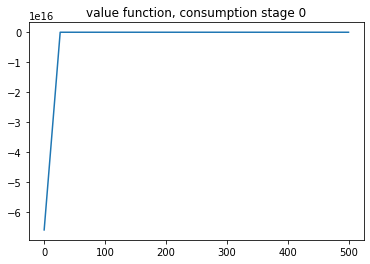

In [63]:
plt.plot(money_range, sols[-3].v_x(x = {'m' : money_range}))
plt.title('value function, consumption stage 0')

Text(0.5, 1.0, 'consumption function, consumption stage 0')

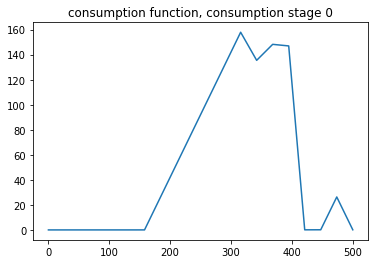

In [70]:
plt.plot(money_range, sols[-6].pi_star(x = {'m' : money_range}, k= {}))
plt.title('consumption function, consumption stage 0')

Text(0.5, 1.0, 'value function, allocation stage 1')

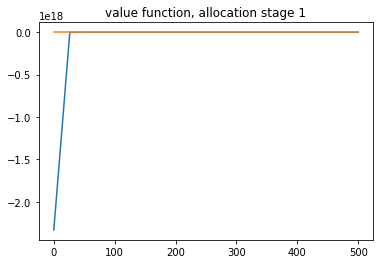

In [71]:
plt.plot(money_range, sols[-5].v_x(x = {'a' : money_range}))
plt.plot(money_range, sols[-5].pi_star(x = {'a' : money_range}, k= {}))
plt.title('value function, allocation stage 1')